# 📊 Reporte de Modelo - Campaña de Marketing
Modelo: LightGBM optimizado con Optuna  

In [66]:
import pandas as pd
import sys
sys.path.append("../")
from src.model_factory import ModelFactory
from src.preprocessing import prepare_data, create_preprocessor, split_data
from src.evaluation_utils import (
    evaluate_model,
    find_best_threshold
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [67]:
df = pd.read_csv("..//results//comparison_results.csv")
df.style.background_gradient(cmap='Blues')

,Model,F1,ROC AUC,Precision,Recall
0,Base,0.537815,0.875576,0.615385,0.477612
1,Optimizado Ajustado,0.563758,0.874702,0.512195,0.626866


El modelo optimizado mejora la sensibilidad (recall): pasa de 47.8% a 62.7% → excelente si el negocio prioriza captar a más clientes potenciales (menos falsos negativos).

Pierde algo de precisión, lo que significa más falsos positivos. Aun así, se compensa si lo importante es no perder oportunidades de conversión.

La métrica F1 mejora moderadamente (de 0.537 a 0.563), lo cual es positivo dado el desbalance de clases.

ROC AUC se mantiene alto en ambos casos (~0.875): ambos modelos tienen buena capacidad de discriminación global.

In [68]:
report_df = pd.read_csv("..//results//classification_report.csv", index_col=0)
report_df.style.background_gradient(cmap='Greens')

,precision,recall,f1-score,support
0,0.930748,0.893617,0.911805,376.000000
1,0.512195,0.626866,0.563758,67.000000
accuracy,0.853273,0.853273,0.853273,0.853273
macro avg,0.721472,0.760241,0.737782,443.000000
weighted avg,0.867445,0.853273,0.859166,443.000000


El modelo es muy preciso al predecir la clase mayoritaria (0): lo esperado dado el desbalance.

Para la clase positiva (1), que es la de interés (clientes que responden), se logra:

- Un recall decente de 62.7%, que indica buen poder de detección.

- Una F1 moderada: esto sugiere un compromiso razonable entre precisión y recall.

La accuracy general (85.3%) parece buena, pero no debe ser la métrica central aquí (por el desbalance de clases).

In [69]:
# Preparar datos y cargar modelo
df = prepare_data("..//data//marketing_campaign.csv")
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).drop('Response', axis=1).columns.tolist()
X = df.drop(columns=['Response'])
y = df['Response']
preprocessor = create_preprocessor(numeric_cols, categorical_cols)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Cargar modelo optimizado
with open("..//models//final_model_pipeline.pkl", "rb") as f:
    opt_pipe = pickle.load(f)

# Modelo base
factory = ModelFactory()
base_model = factory.get_default_models()['LightGBM']
base_pipe = Pipeline([('preprocessing', preprocessor), ('model', base_model)])
base_pipe.fit(X_train, y_train)

# Evaluar
metrics_base, fpr_base, tpr_base = evaluate_model("Base", base_pipe, X_test, y_test)
metrics_opt, fpr_opt, tpr_opt = evaluate_model("Optimizado", opt_pipe, X_test, y_test)

   Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0        1957  Graduation         Single  58138.0        0         0   
1        1954  Graduation         Single  46344.0        1         1   
2        1965  Graduation       Together  71613.0        0         0   
3        1984  Graduation       Together  26646.0        1         0   
4        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  ...  NumCatalogPurchases  \
0  2012-09-04       58       635         88  ...                   10   
1  2014-03-08       38        11          1  ...                    1   
2  2013-08-21       26       426         49  ...                    2   
3  2014-02-10       26        11          4  ...                    0   
4  2014-01-19       94       173         43  ...                    3   

   NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0                  4                  7             0    

c:\Users\nicol\OneDrive\Escritorio\DATA SCIENCE\Portfolio\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nicol\OneDrive\Escritorio\DATA SCIENCE\Portfolio\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nicol\OneDrive\Escritorio\DATA SCIENCE\Portfolio\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\nicol\OneDrive\Escritorio\DATA SCIENCE\Portfolio\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


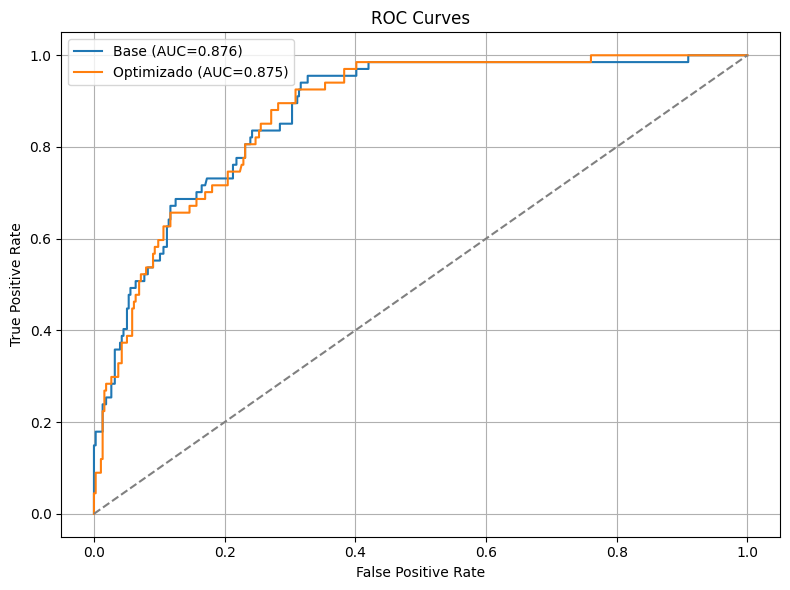

In [70]:
results = [
    ("Base", fpr_base, tpr_base, metrics_base['ROC AUC']),
    ("Optimizado", fpr_opt, tpr_opt, metrics_opt['ROC AUC'])
]


plt.figure(figsize=(8, 6))
for label, fpr, tpr, auc_val in results:
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc_val:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.tight_layout()

Ambos modelos tienen curvas ROC muy similares

El AUC del modelo base es marginalmente superior (0.001)
Esta diferencia es tan pequeña que no es significativa. En la práctica, ambos modelos tienen la misma capacidad de clasificación probabilística.

Las curvas están alejadas de la diagonal gris (random guess)
Indica que ambos modelos superan ampliamente un clasificador aleatorio y tienen alta calidad global.


Aunque el modelo base tiene una ligera ventaja en AUC, el modelo optimizado mejora significativamente el recall y el F1-score, como ya analizamos antes.


c:\Users\nicol\OneDrive\Escritorio\DATA SCIENCE\Portfolio\.venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


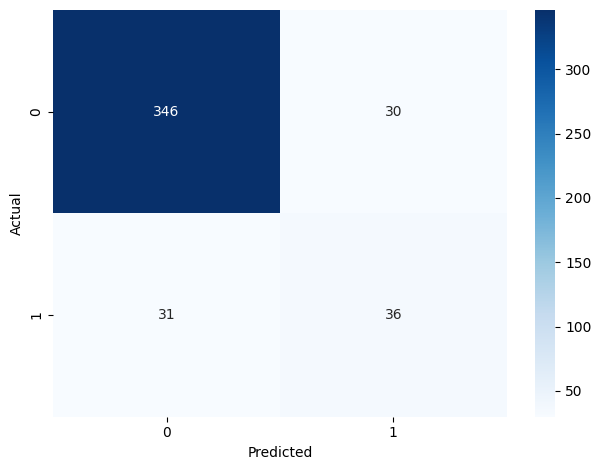

In [71]:
y_test_probs = opt_pipe.predict_proba(X_test)[:, 1]
threshold = 0.5  # Puedes actualizar con tu mejor threshold
y_pred_thresh = (y_test_probs >= threshold).astype(int)


cm = confusion_matrix(y_test, y_pred_thresh)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

El modelo tiene un comportamiento conservador, prioriza evitar falsos positivos, pero captura más de la mitad de los verdaderos clientes potenciales.

La matriz refleja un modelo útil en marketing: detecta una buena proporción de clientes que sí responderán, y mantiene bajos los errores de clasificación en general.


c:\Users\nicol\OneDrive\Escritorio\DATA SCIENCE\Portfolio\.venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


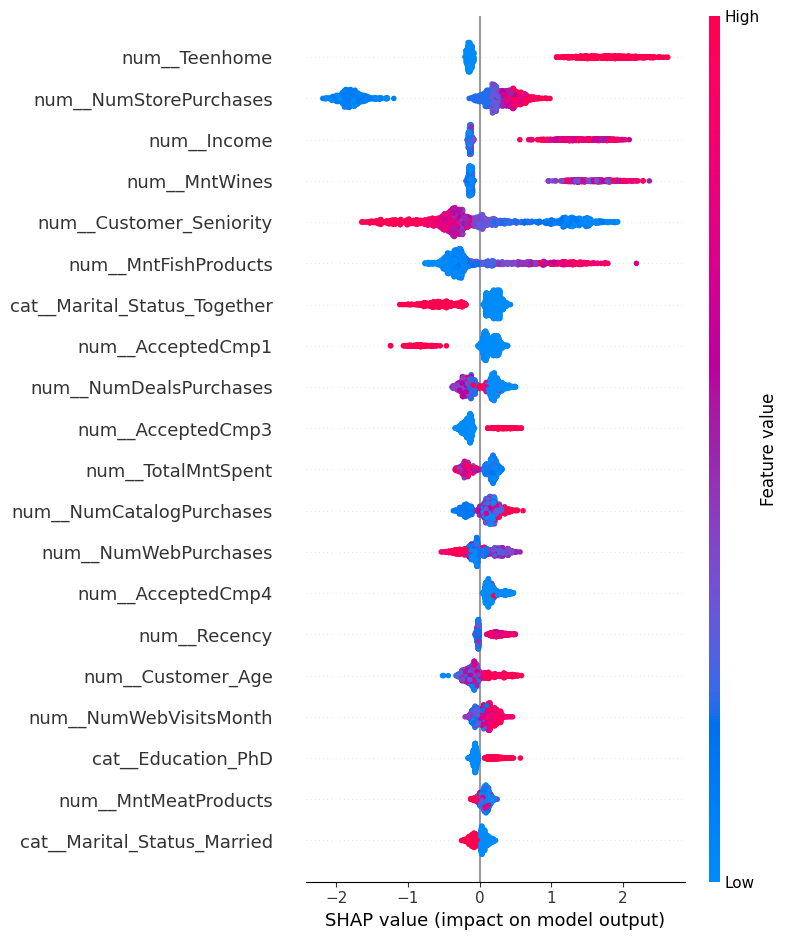

In [72]:
X_train_proc = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.TreeExplainer(opt_pipe.named_steps['model'])
shap_values = explainer.shap_values(X_train_proc)

shap.summary_plot(shap_values, features=X_train_proc, feature_names=feature_names)

📌 Variables más influyentes
1. num__Teenhome: Tener adolescentes en casa impacta negativamente.
Posible causa: mayor carga familiar = menos tiempo o disposición.

1. num__NumStorePurchases. Clientes que compran frecuentemente en tienda aumentan la probabilidad de respuesta.
Claramente un rasgo de clientes comprometidos.

1. num__Income: Ingresos altos también asocian positivamente con respuesta.
Probable correlación con capacidad adquisitiva y afinidad con campañas.

4. num__MntWines: Altos gastos en vino son muy predictivos de respuesta.
Probablemente un segmento valioso y fidelizado.

5. num__Customer_Seniority: Tiempo como cliente tiene influencia mixta.
Clientes más antiguos pueden tener mayor lealtad (rojo positivo), pero también cierto desgaste (rojo negativo en menor grado).

💡 Otras variables destacadas

num__AcceptedCmp1, num__AcceptedCmp3, etc.:
Historial de aceptación de campañas anteriores predice fuertemente una futura respuesta.

cat__Marital_Status_Together:
Sugiere un perfil que responde menos comparado con otros estados civiles.

num__Recency:
Clientes que compraron recientemente (baja recency) tienden a responder más.


# Conclusión general del modelo

El modelo se basa en señales de compromiso pasado (compras, campañas aceptadas), perfil económico (ingresos, vinos) y hábitos de compra para predecir la probabilidad de respuesta.

SHAP confirma que el modelo no es una caja negra: sus decisiones son interpretables y alineadas con lógica de negocio.